In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np 
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from skimage import exposure
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.optimizers import RMSprop

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv


# Load Datasets

In [2]:
# Import data into a dataframe
train= pd.read_csv("/kaggle/input/digit-recognizer/train.csv")
test= pd.read_csv("/kaggle/input/digit-recognizer/test.csv")

In [3]:
print(f"Train Data Info: {train.info()}\n")
train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 251.5 MB
Train Data Info: None



,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
print(f"Test Data Info: {test.info()}\n")
test.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28000 entries, 0 to 27999
Columns: 784 entries, pixel0 to pixel783
dtypes: int64(784)
memory usage: 167.5 MB
Test Data Info: None



,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
target= train["label"]
features= train.drop("label", axis=1)

# Split Training Dataset to Targets and Features

In [6]:
target= train["label"]
features= train.drop("label", axis=1)

In [7]:
print(target.head())
features.head()

0    1
1    0
2    1
3    4
4    0
Name: label, dtype: int64


,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


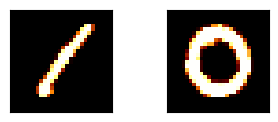

In [8]:
# plot some of the numbers
plt.figure(figsize=(8,6))
for digit_num in range(0,2):
    plt.subplot(5,5,digit_num+1)
    grid_data = features.iloc[digit_num].to_numpy().reshape(28,28)  # reshape from 1d to 2d pixel array
    plt.imshow(grid_data, interpolation = "none", cmap = "afmhot")
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()

# Preprocessing the Datasets

#### Features
Following my previous notebook I will doing the following using a function.
- **Data Noramlization** scales the pixel values to a certain range (usually 0 to 1), which can help with numerical stability and also ensure that all features have the same scale.
- **Standardize** makes the features more like standard normally distributed data: Gaussian with zero mean and unit variance
- **Scaling Data** is necessary because many machine learning algorithms (especially deep learning algorithms) expect input data in a certain shape.

In [9]:
def preprocess_data(data):
    # Normalize the data
    feat_norm = data / 255.0

    # Initialize a new StandardScaler instance
    scaler = StandardScaler()

    # Fit the scaler to the data
    scaler.fit(feat_norm)

    # Transform the data
    feat_scaled = scaler.transform(feat_norm)
    
    # Reshape the data to 28x28 images
    feat_reshape = feat_scaled.reshape(data.shape[0], 28, 28, 1)
    
    return feat_reshape

In [10]:
feat_train= preprocess_data(features)
feat_test= preprocess_data(test)

In [11]:
print(f"Train shape: {feat_train.shape}")
print(f"Test shape: {feat_test.shape}")
print(f"Train datatype: {type(feat_train)}")
print(f"Test datatype: {type(feat_test)}")

Train shape: (42000, 28, 28, 1)
Test shape: (28000, 28, 28, 1)
Train datatype: <class 'numpy.ndarray'>
Test datatype: <class 'numpy.ndarray'>


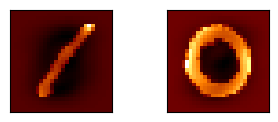

In [12]:
# visualizing some of the numbers preprocessed image
plt.figure(figsize=(8,6))
for digit_num in range(0,2):
    plt.subplot(5,5,digit_num+1)
    grid_data = feat_train[digit_num]
    plt.imshow(grid_data, interpolation = "none", cmap = "afmhot")
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()

In [13]:
# Encoding Label data 
cat_target= to_categorical(target, )
target_classes = cat_target.shape[1]
print(cat_target)
print(f"Classes: {target_classes}")


[[0. 1. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]]
Classes: 10


# Test Train Split

In [14]:
X_train, X_test, y_train, y_test = train_test_split(feat_train, cat_target, test_size=0.1, random_state=42)

# Build the Model

In [15]:
model = Sequential()
model.add(Flatten(input_shape=(28, 28, 1)))
model.add(Dense(64, activation='relu'))
model.add(Dense(target_classes, activation='softmax')) 

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 64)                50240     
                                                                 
 dense_1 (Dense)             (None, 10)                650       
                                                                 
Total params: 50,890
Trainable params: 50,890
Non-trainable params: 0
_________________________________________________________________


In [16]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [17]:
model.fit(X_train, y_train, epochs=10, batch_size=64)

Epoch 1/10
591/591 [==============================] - 2s 2ms/step - loss: 0.3405 - accuracy: 0.9028
Epoch 2/10
591/591 [==============================] - 1s 2ms/step - loss: 0.1400 - accuracy: 0.9590
Epoch 3/10
591/591 [==============================] - 1s 2ms/step - loss: 0.0955 - accuracy: 0.9724
Epoch 4/10
591/591 [==============================] - 1s 2ms/step - loss: 0.0711 - accuracy: 0.9786
Epoch 5/10
591/591 [==============================] - 1s 2ms/step - loss: 0.0551 - accuracy: 0.9837
Epoch 6/10
591/591 [==============================] - 1s 2ms/step - loss: 0.0424 - accuracy: 0.9879
Epoch 7/10
591/591 [==============================] - 1s 2ms/step - loss: 0.0325 - accuracy: 0.9906
Epoch 8/10
591/591 [==============================] - 1s 2ms/step - loss: 0.0266 - accuracy: 0.9926
Epoch 9/10
591/591 [==============================] - 1s 2ms/step - loss: 0.0198 - accuracy: 0.9951
Epoch 10/10
591/591 [==============================] - 1s 2ms/step - loss: 0.0152 - accuracy: 0.9965